In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns

from statsmodels.stats.contingency_tables import mcnemar
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score



Import Csv file

In [132]:
#Load data
#data = pd.read_csv("C:/Users/admin/OneDrive/Desktop/Stat i AI/Individuel/HR_data.csv")
data = pd.read_csv("C:/Users/jakob/OneDrive/Desktop/Stat i AI/Individuel/HR_data.csv")
display(data.head())

# Define feature and target columns
numeric_features = ['HR_Mean', 'HR_Median', 'HR_std', 'HR_Min', 'HR_Max', 'HR_AUC']
categorical_features = ['Cohort', 'Phase']
target_column = 'Frustrated'

# Prepare data
X = data[numeric_features + categorical_features]
y = data[target_column]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

,Unnamed: 0,HR_Mean,HR_Median,HR_std,HR_Min,HR_Max,HR_AUC,Round,Phase,Individual,Puzzler,Frustrated,Cohort
0,0,77.965186,78.00,3.345290,73.23,83.37,22924.945,round_3,phase3,1,1,1,D1_1
1,1,70.981097,70.57,2.517879,67.12,78.22,21930.400,round_3,phase2,1,1,5,D1_1
2,2,73.371959,73.36,3.259569,67.88,80.22,21647.085,round_3,phase1,1,1,0,D1_1
3,3,78.916822,77.88,4.054595,72.32,84.92,25258.905,round_2,phase3,1,1,1,D1_1
4,4,77.322226,74.55,6.047603,70.52,90.15,23890.565,round_2,phase2,1,1,5,D1_1


Plot stress mod hartrate mean

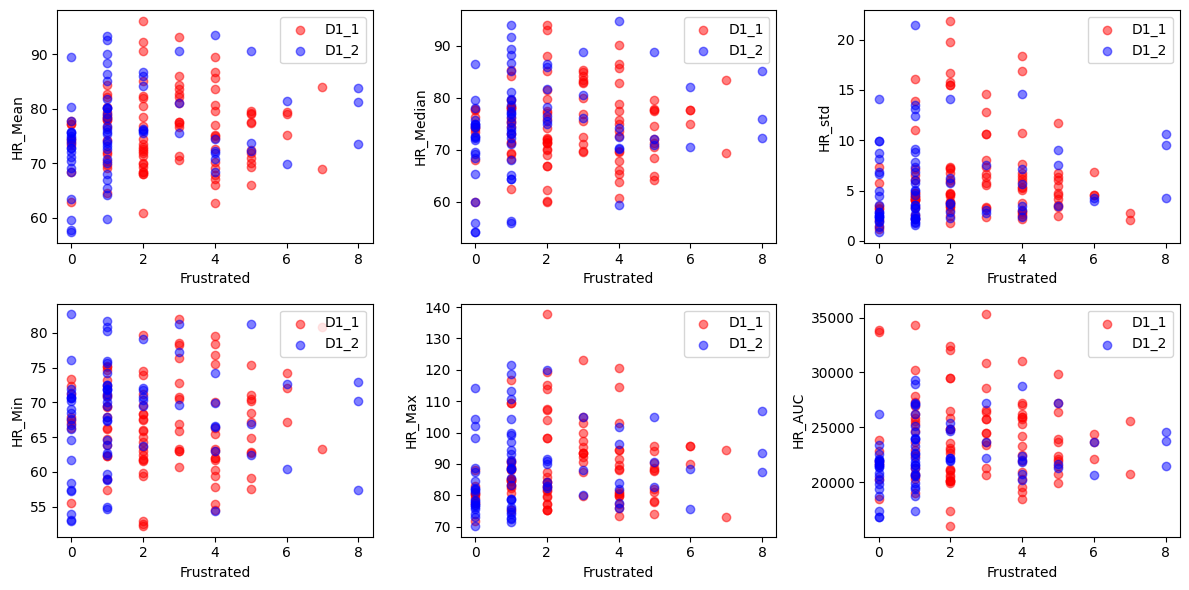

In [133]:
# Visualize data
unique_cohorts = data['Cohort'].unique()
cohort_colors = {'D1_1': 'red', 'D1_2': 'blue'}

plt.figure(figsize=(12, 6))
for i, column in enumerate(numeric_features):
    plt.subplot(2, 3, i + 1)
    for cohort in unique_cohorts:
        cohort_data = data[data['Cohort'] == cohort]
        color = cohort_colors.get(cohort, 'gray')
        plt.scatter(cohort_data['Frustrated'], cohort_data[column], alpha=0.5, label=cohort, color=color)
    plt.xlabel('Frustrated')
    plt.ylabel(column)
    plt.legend()
plt.tight_layout()
plt.show()

Bootstrap funktion

In [134]:

def bootstrap_confidence_interval(metric_func, y_true, y_pred, num_samples=1000, alpha=0.95):
    bootstrapped_scores = []
    for _ in range(num_samples):
        indices = resample(range(len(y_true)))
        if len(set(y_true[indices])) < 2:  # Skip resamples with less than 2 classes
            continue
        score = metric_func(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    lower_bound = sorted_scores[int((1.0-alpha)/2.0 * len(sorted_scores))]
    upper_bound = sorted_scores[int((1.0+alpha)/2.0 * len(sorted_scores))]
    return np.mean(sorted_scores), lower_bound, upper_bound

Random Forest Classifier:

In [136]:
# Træn model
model = RandomForestClassifier(n_estimators=10000, random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluer
y_pred_rf = model.predict(X_test_scaled)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=1))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.38      0.50        13
           1       0.32      0.43      0.36        14
           2       0.13      0.33      0.19         6
           3       0.00      0.00      1.00         3
           4       0.40      0.25      0.31         8
           5       0.00      0.00      1.00         6
           6       1.00      0.00      0.00         1

    accuracy                           0.29        51
   macro avg       0.37      0.20      0.48        51
weighted avg       0.37      0.29      0.47        51



Plot tree

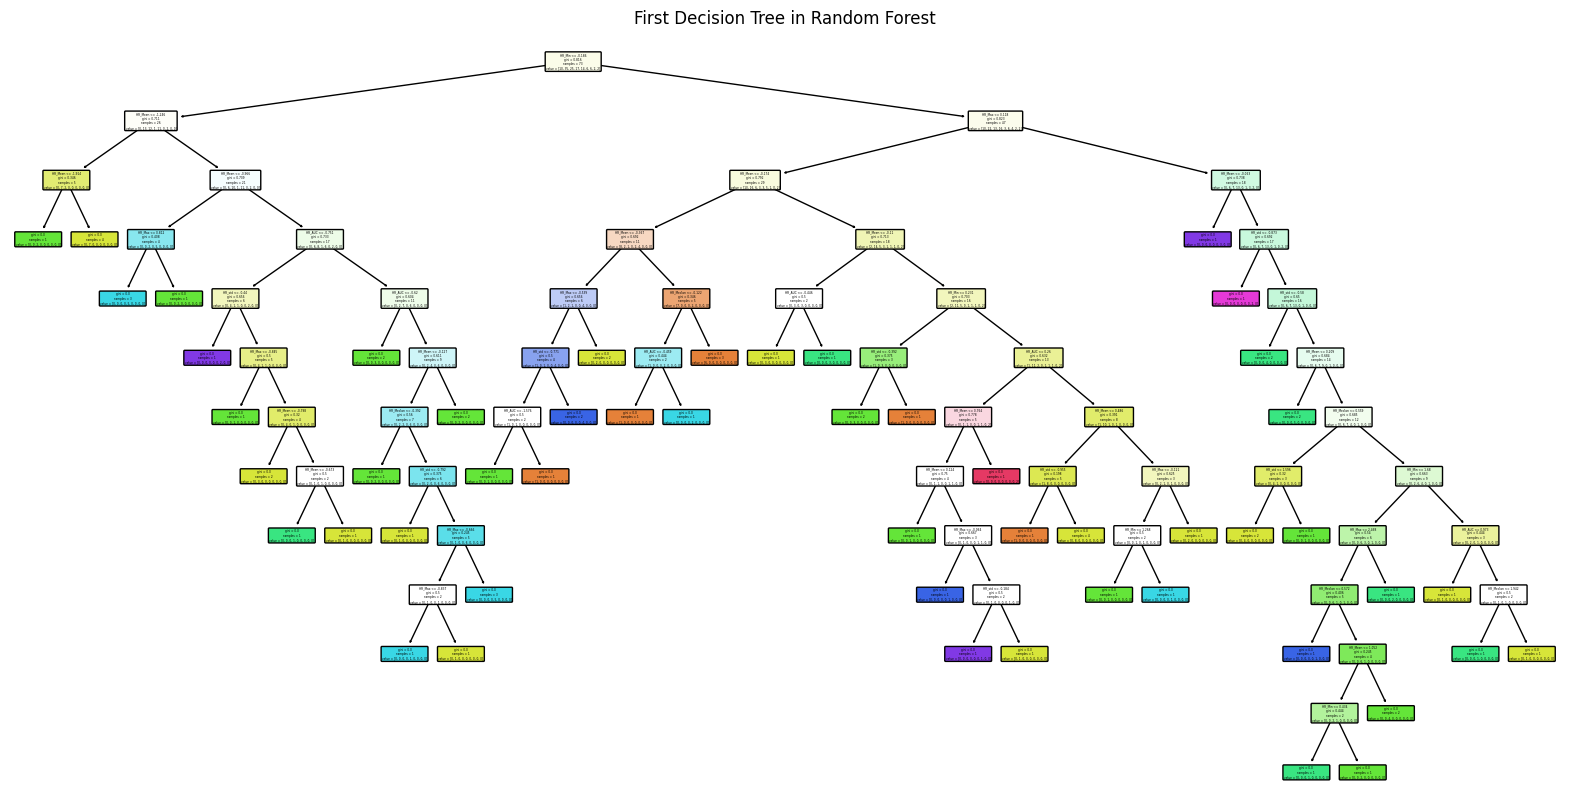

In [138]:
trænr = 1
feature_names_list = X.columns.tolist()
first_tree = model.estimators_[trænr - 1]

# Plot
plt.figure(figsize=(20, 10))
tree.plot_tree(first_tree, feature_names=feature_names_list, filled=True, rounded=True)
plt.title('First Decision Tree in Random Forest')
plt.show()


Random Forest cross validation

In [139]:
# Define the pipeline 
pipeline_rf = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

# Define the parameter grid 
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Perform the grid search
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=10, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)

# Evaluate 
best_model_rf = grid_search_rf.best_estimator_
y_pred_rf = best_model_rf.predict(X_test)
print(f"\nBest mean test score: {grid_search_rf.best_score_}")
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0))


cv_results_rf = pd.DataFrame(grid_search_rf.cv_results_)
display(cv_results_rf[['mean_test_score', 'std_test_score']])

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


c:\Users\jakob\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(



Best mean test score: 0.17878787878787877
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.62      0.70        13
           1       0.60      0.43      0.50        14
           2       0.42      0.83      0.56         6
           3       0.17      0.33      0.22         3
           4       0.40      0.25      0.31         8
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0

    accuracy                           0.43        51
   macro avg       0.26      0.27      0.25        51
weighted avg       0.49      0.43      0.44        51



,mean_test_score,std_test_score
0,0.126515,0.066308
1,0.160606,0.078203
2,0.152273,0.081484
3,0.168939,0.113689
4,0.143939,0.094561
...,...,...
103,0.127273,0.088918
104,0.152273,0.092502
105,0.128030,0.113153
106,0.136364,0.112622


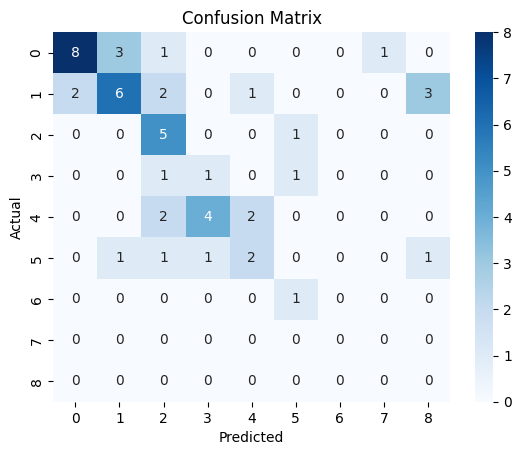

In [140]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Confidence interval


In [141]:

report = classification_report(y_test, y_pred, output_dict=True)


print("Confidence Intervals for Each Class:")
for label, metrics in report.items():
    if label in ['accuracy', 'macro avg', 'weighted avg']:
        continue
    precision_ci = bootstrap_confidence_interval(lambda y_true, y_pred: precision_score(y_true, y_pred, labels=[label], average='weighted', zero_division=0), y_test.to_numpy(), y_pred)
    recall_ci = bootstrap_confidence_interval(lambda y_true, y_pred: recall_score(y_true, y_pred, labels=[label], average='weighted', zero_division=0), y_test.to_numpy(), y_pred)
    f1_ci = bootstrap_confidence_interval(lambda y_true, y_pred: f1_score(y_true, y_pred, labels=[label], average='weighted', zero_division=0), y_test.to_numpy(), y_pred)
    print(f"Class {label} - Precision CI: {precision_ci}, Recall CI: {recall_ci}, F1 CI: {f1_ci}")


print("\nConfidence Intervals for Overall Metrics:")
overall_precision_ci = bootstrap_confidence_interval(lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted', zero_division=0), y_test.to_numpy(), y_pred)
overall_recall_ci = bootstrap_confidence_interval(lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted', zero_division=0), y_test.to_numpy(), y_pred)
overall_f1_ci = bootstrap_confidence_interval(lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted', zero_division=0), y_test.to_numpy(), y_pred)
print(f"Overall Precision CI: {overall_precision_ci}, Overall Recall CI: {overall_recall_ci}, Overall F1 CI: {overall_f1_ci}")


c:\Users\jakob\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jakob\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jakob\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

Confidence Intervals for Each Class:
Class 0 - Precision CI: (0.798070392967026, 0.5, 1.0), Recall CI: (0.6152758987219463, 0.3333333333333333, 0.8823529411764706), F1 CI: (0.6882024366095729, 0.4444444444444444, 0.88)
Class 1 - Precision CI: (0.6014789289958407, 0.25, 0.8888888888888888), Recall CI: (0.43468885137442986, 0.18181818181818182, 0.6923076923076923), F1 CI: (0.48933628787406364, 0.1904761904761905, 0.7142857142857142)
Class 2 - Precision CI: (0.4147733992718294, 0.14285714285714285, 0.6923076923076923), Recall CI: (0.8318965562215562, 0.4444444444444444, 1.0), F1 CI: (0.5345945828961544, 0.21052631578947362, 0.8)
Class 3 - Precision CI: (0.16760545288045287, 0.0, 0.5), Recall CI: (0.3102695887445887, 0.0, 1.0), F1 CI: (0.21310893958982194, 0.0, 0.6)
Class 4 - Precision CI: (0.4012294372294372, 0.0, 1.0), Recall CI: (0.24779418996036645, 0.0, 0.625), F1 CI: (0.2949177055822836, 0.0, 0.6153846153846153)
Class 5 - Precision CI: (0.0, 0.0, 0.0), Recall CI: (0.0, 0.0, 0.0), F1 

Logistical regresion

In [142]:
pipeline_lr = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced', max_iter=10000))
])

# Define the parameter grid 
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'classifier__penalty': ['l2']  # 'l2' penalty is supported by all solvers
}

# Perform the grid search
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=10, n_jobs=-1, verbose=2)
grid_search_lr.fit(X_train, y_train)

# Evaluate
best_model_lr = grid_search_lr.best_estimator_
y_pred_lr = best_model_lr.predict(X_test)
print(f"\nBest mean test score: {grid_search_lr.best_score_}")
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=1))


cv_results_lr = pd.DataFrame(grid_search_lr.cv_results_)
display(cv_results_lr[['mean_test_score', 'std_test_score']])

Fitting 10 folds for each of 25 candidates, totalling 250 fits


c:\Users\jakob\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(



Best mean test score: 0.1977272727272727
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.54      0.61        13
           1       0.33      0.14      0.20        14
           2       0.00      0.00      1.00         6
           3       0.20      0.33      0.25         3
           4       0.38      0.38      0.38         8
           5       0.22      0.33      0.27         6
           6       0.00      0.00      1.00         1
           7       0.00      1.00      0.00         0
           8       0.00      1.00      0.00         0

    accuracy                           0.29        51
   macro avg       0.20      0.41      0.41        51
weighted avg       0.37      0.29      0.45        51



,mean_test_score,std_test_score
0,0.119697,0.078569
1,0.119697,0.078569
2,0.178788,0.093842
3,0.119697,0.078569
4,0.119697,0.078569
5,0.145455,0.087420
6,0.145455,0.087420
7,0.162879,0.107365
8,0.145455,0.087420
9,0.145455,0.087420


In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Confidence intervals by bootstraping

In [143]:

report = classification_report(y_test, y_pred, output_dict=True)

print("Confidence Intervals for Each Class:")
for label, metrics in report.items():
    if label in ['accuracy', 'macro avg', 'weighted avg']:
        continue
    precision_ci = bootstrap_confidence_interval(lambda y_true, y_pred: precision_score(y_true, y_pred, labels=[label], average='weighted', zero_division=0), y_test.to_numpy(), y_pred)
    recall_ci = bootstrap_confidence_interval(lambda y_true, y_pred: recall_score(y_true, y_pred, labels=[label], average='weighted', zero_division=0), y_test.to_numpy(), y_pred)
    f1_ci = bootstrap_confidence_interval(lambda y_true, y_pred: f1_score(y_true, y_pred, labels=[label], average='weighted', zero_division=0), y_test.to_numpy(), y_pred)
    print(f"Class {label} - Precision CI: {precision_ci}, Recall CI: {recall_ci}, F1 CI: {f1_ci}")


print("\nConfidence Intervals for Overall Metrics:")
overall_precision_ci = bootstrap_confidence_interval(lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted', zero_division=0), y_test.to_numpy(), y_pred)
overall_recall_ci = bootstrap_confidence_interval(lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted', zero_division=0), y_test.to_numpy(), y_pred)
overall_f1_ci = bootstrap_confidence_interval(lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted', zero_division=0), y_test.to_numpy(), y_pred)
print(f"Overall Precision CI: {overall_precision_ci}, Overall Recall CI: {overall_recall_ci}, Overall F1 CI: {overall_f1_ci}")


Confidence Intervals for Each Class:


c:\Users\jakob\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jakob\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jakob\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

Class 0 - Precision CI: (0.8014320977569043, 0.5, 1.0), Recall CI: (0.617585916097595, 0.3333333333333333, 0.8888888888888888), F1 CI: (0.6923850308000836, 0.4615384615384615, 0.888888888888889)
Class 1 - Precision CI: (0.6020725305525229, 0.2857142857142857, 0.9), Recall CI: (0.4201604883063945, 0.16666666666666666, 0.7142857142857143), F1 CI: (0.4875849243737568, 0.19354838709677422, 0.7027027027027027)
Class 2 - Precision CI: (0.4120755701470871, 0.13333333333333333, 0.7), Recall CI: (0.8234050366300366, 0.5, 1.0), F1 CI: (0.542407281813588, 0.22222222222222224, 0.8)
Class 3 - Precision CI: (0.16893963813963817, 0.0, 0.5), Recall CI: (0.3115678571428571, 0.0, 1.0), F1 CI: (0.1945174714088801, 0.0, 0.6153846153846154)
Class 4 - Precision CI: (0.4062658008658009, 0.0, 1.0), Recall CI: (0.24080767288267288, 0.0, 0.625), F1 CI: (0.2880289565503222, 0.0, 0.6153846153846153)
Class 5 - Precision CI: (0.0, 0.0, 0.0), Recall CI: (0.0, 0.0, 0.0), F1 CI: (0.0, 0.0, 0.0)
Class 6 - Precision CI:

McNemar's test

In [145]:
# Predictions
logistic_preds = best_model_lr.predict(X_test)
random_forest_preds = best_model_rf.predict(X_test)

# Contingency table
contingency_table = pd.crosstab(logistic_preds, random_forest_preds, rownames=['Logistic'], colnames=['Random Forest'])
print(f'Contingency Table:\n{contingency_table}')

# McNemar's test
result = mcnemar(contingency_table, exact=True)
display(f'McNemar Test: statistic = {result.statistic}, p-value = {result.pvalue}')


Contingency Table:
Random Forest  0  1  2  3  4  5  7  8
Logistic                             
0              5  2  0  1  0  0  0  0
1              3  2  0  1  0  1  0  0
2              1  4  5  0  0  0  0  0
3              0  0  2  3  3  0  0  0
4              0  0  1  1  3  0  0  0
5              0  0  1  0  1  1  0  0
6              0  0  1  0  0  0  0  0
7              0  0  0  0  1  1  1  0
8              0  0  1  2  1  0  0  2


'McNemar Test: statistic = 2.0, p-value = 1.0'